In [31]:
import cudf 
%load_ext cudf.pandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_columns',0)

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [32]:
# %%cudf.pandas.profile
df=pd.read_csv('yellow_tripdata_2023-01.csv',low_memory=False)

In [34]:
df.shape

(3066812, 19)

In [35]:
#process only few records in order to save memory
df=df.head(1000000)

In [36]:
df.shape

(1000000, 19)

In [11]:
# %%cudf.pandas.profile
# df=cudf.read_csv('yellow_tripdata_2023-01.csv')

In [37]:
after_filtered_df=df[df['VendorID'] != 'VendorID']

In [38]:
# %%cudf.pandas.profile
after_filtered_df['VendorID']=after_filtered_df['VendorID'].astype('category')
after_filtered_df['tpep_pickup_datetime']=pd.to_datetime(after_filtered_df['tpep_pickup_datetime'])
after_filtered_df['tpep_dropoff_datetime']=pd.to_datetime(after_filtered_df['tpep_dropoff_datetime'])
after_filtered_df['passenger_count']=pd.to_numeric(after_filtered_df['passenger_count'],downcast='integer')
after_filtered_df['trip_distance']=pd.to_numeric(after_filtered_df['trip_distance'])
after_filtered_df['RatecodeID']=after_filtered_df['RatecodeID'].astype('category')
after_filtered_df['store_and_fwd_flag']=after_filtered_df['store_and_fwd_flag'].astype('category')
after_filtered_df['PULocationID']=pd.to_numeric(after_filtered_df['PULocationID'])
after_filtered_df['DOLocationID']=pd.to_numeric(after_filtered_df['DOLocationID'])
after_filtered_df['payment_type']=after_filtered_df['payment_type'].astype('category')
after_filtered_df['fare_amount']=pd.to_numeric(after_filtered_df['fare_amount'])
after_filtered_df['extra']=pd.to_numeric(after_filtered_df['extra'])
after_filtered_df['mta_tax']=pd.to_numeric(after_filtered_df['mta_tax'])
after_filtered_df['tip_amount']=pd.to_numeric(after_filtered_df['tip_amount'])
after_filtered_df['tolls_amount']=pd.to_numeric(after_filtered_df['tolls_amount'])
after_filtered_df['improvement_surcharge']=pd.to_numeric(after_filtered_df['improvement_surcharge'])
after_filtered_df['total_amount']=pd.to_numeric(after_filtered_df['total_amount'])
after_filtered_df['congestion_surcharge']=pd.to_numeric(after_filtered_df['congestion_surcharge'])
after_filtered_df['airport_fee']=pd.to_numeric(after_filtered_df['airport_fee'])

In [39]:
#after_filtered_df.to_csv('/home/bibek/Desktop/uber_data_engineering/after_some_cleaning.csv')

In [40]:
after_filtered_df['pickup_year'] = after_filtered_df['tpep_pickup_datetime'].dt.year
after_filtered_df['pickup_month'] = after_filtered_df['tpep_pickup_datetime'].dt.month
after_filtered_df['pickup_day'] = after_filtered_df['tpep_pickup_datetime'].dt.day
after_filtered_df['pickup_weekday'] = after_filtered_df['tpep_pickup_datetime'].dt.weekday
after_filtered_df['pickup_hour'] = after_filtered_df['tpep_pickup_datetime'].dt.hour
after_filtered_df['dropoff_year'] = after_filtered_df['tpep_dropoff_datetime'].dt.year
after_filtered_df['dropoff_month'] = after_filtered_df['tpep_dropoff_datetime'].dt.month
after_filtered_df['dropoff_day'] = after_filtered_df['tpep_dropoff_datetime'].dt.day
after_filtered_df['dropoff_weekday'] = after_filtered_df['tpep_dropoff_datetime'].dt.weekday
after_filtered_df['dropoff_hour'] = after_filtered_df['tpep_dropoff_datetime'].dt.hour

In [41]:
#if tpep_pickup_datetime and tpep_dropoff_datetime is same logically it is not possible
after_duplicate_filtered_df=after_filtered_df['tpep_pickup_datetime'] != after_filtered_df['tpep_dropoff_datetime']
after_duplicate_filtered_df = after_filtered_df[after_duplicate_filtered_df]
after_duplicate_filtered_df.sample(4)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_year,pickup_month,pickup_day,pickup_weekday,pickup_hour,dropoff_year,dropoff_month,dropoff_day,dropoff_weekday,dropoff_hour
608827,2,2023-01-07 22:54:50,2023-01-07 23:11:45,1,8.36,1.0,N,132,39,1,33.8,1.0,0.5,7.00,0.0,1.0,44.55,0.0,1.25,2023,1,7,5,22,2023,1,7,5,23
235033,2,2023-01-04 09:57:03,2023-01-04 10:05:53,1,1.86,1.0,N,236,161,1,11.4,0.0,0.5,3.08,0.0,1.0,18.48,2.5,0.00,2023,1,4,2,9,2023,1,4,2,10
304607,1,2023-01-04 21:24:22,2023-01-04 21:29:54,2,0.90,1.0,N,263,237,2,6.5,3.5,0.5,0.00,0.0,1.0,11.50,2.5,0.00,2023,1,4,2,21,2023,1,4,2,21
417362,2,2023-01-06 03:31:22,2023-01-06 03:49:14,3,7.61,1.0,N,48,244,2,31.7,1.0,0.5,0.00,0.0,1.0,36.70,2.5,0.00,2023,1,6,4,3,2023,1,6,4,3


In [42]:
after_duplicate_filtered_df.sample(5).reset_index(drop=True)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_year,pickup_month,pickup_day,pickup_weekday,pickup_hour,dropoff_year,dropoff_month,dropoff_day,dropoff_weekday,dropoff_hour
0,1,2023-01-08 00:25:12,2023-01-08 00:43:41,3,8.70,1.0,N,263,79,1,35.9,3.5,0.5,0.00,0.0,1.0,40.90,2.5,0.0,2023,1,8,6,0,2023,1,8,6,0
1,2,2023-01-10 07:26:57,2023-01-10 07:35:27,1,1.48,1.0,N,113,231,1,10.0,0.0,0.5,2.80,0.0,1.0,16.80,2.5,0.0,2023,1,10,1,7,2023,1,10,1,7
2,1,2023-01-04 08:58:52,2023-01-04 09:15:36,3,1.70,1.0,N,186,163,1,13.5,2.5,0.5,3.50,0.0,1.0,21.00,2.5,0.0,2023,1,4,2,8,2023,1,4,2,9
3,2,2023-01-03 09:04:28,2023-01-03 09:10:38,2,1.06,1.0,N,163,48,1,7.9,0.0,0.5,2.38,0.0,1.0,14.28,2.5,0.0,2023,1,3,1,9,2023,1,3,1,9
4,2,2023-01-08 17:21:28,2023-01-08 17:26:49,2,1.41,1.0,N,43,239,1,7.9,0.0,0.5,1.50,0.0,1.0,13.40,2.5,0.0,2023,1,8,6,17,2023,1,8,6,17


In [43]:
after_duplicate_filtered_df['id'] = after_duplicate_filtered_df.index+1

In [44]:
#create dataframe date_time_dim
date_time_dim=after_duplicate_filtered_df[['id','tpep_pickup_datetime','pickup_year','pickup_month',
               'pickup_day','pickup_weekday','pickup_hour','tpep_dropoff_datetime',
              'dropoff_year','dropoff_month','dropoff_day','dropoff_weekday','dropoff_hour']]

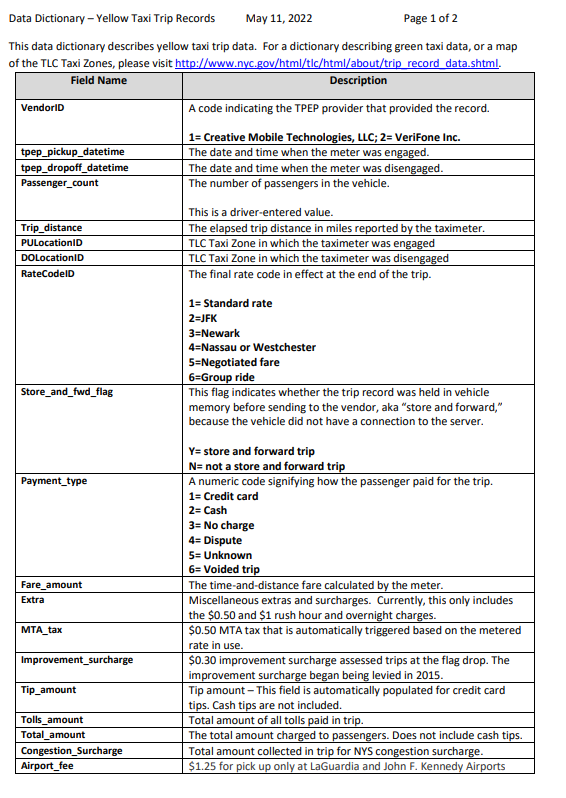

In [45]:
from IPython import display
display.Image("/home/bibek/Desktop/uber_data_engineering/pictures/3.png")

In [46]:
#prepare data for vendor_dim table
vendor_mode_data={'vendor_id':[1,2],
                  'vendor_description':["Creative Mobile Technologies, LLC","VeriFone Inc."]
}
vendor_dim=pd.DataFrame(vendor_mode_data)
vendor_dim

,vendor_id,vendor_description
0,1,"Creative Mobile Technologies, LLC"
1,2,VeriFone Inc.


In [47]:
#prepare data for payment_dim table
payment_dim_data={'payment_id':[1,2,3,4,5,6],
                  'payment_description':["Credit card, LLC","Cash","No charge","Dispute","Unknown","Voided trip"]
}
payment_dim=pd.DataFrame(payment_dim_data)
payment_dim

,payment_id,payment_description
0,1,"Credit card, LLC"
1,2,Cash
2,3,No charge
3,4,Dispute
4,5,Unknown
5,6,Voided trip


In [48]:
#prepare data for rate_dim table
rate_dim_data={'rate_id':[1,2,3,4,5,6],
                  'rate_description':["Standard rate","JFK","Newark","Nassau or Westchester",
                                         "Negotiated fare","Group ride"]
}
rate_dim=pd.DataFrame(rate_dim_data)
rate_dim

,rate_id,rate_description
0,1,Standard rate
1,2,JFK
2,3,Newark
3,4,Nassau or Westchester
4,5,Negotiated fare
5,6,Group ride


In [49]:
#prepare data for zones_dim table
zones_dim = pd.read_csv('/home/bibek/Desktop/uber_data_engineering/data/taxi_zones.csv', low_memory=False)
zones_dim.head()

,OBJECTID,Shape_Leng,the_geom,Shape_Area,zone,LocationID,borough
0,1,0.116357,MULTIPOLYGON (((-74.18445299999996 40.69499599...,0.000782,Newark Airport,1,EWR
1,2,0.433470,MULTIPOLYGON (((-73.82337597260663 40.63898704...,0.004866,Jamaica Bay,2,Queens
2,3,0.084341,MULTIPOLYGON (((-73.84792614099985 40.87134223...,0.000314,Allerton/Pelham Gardens,3,Bronx
3,4,0.043567,MULTIPOLYGON (((-73.97177410965318 40.72582128...,0.000112,Alphabet City,4,Manhattan
4,5,0.092146,MULTIPOLYGON (((-74.17421738099989 40.56256808...,0.000498,Arden Heights,5,Staten Island


In [50]:
#prepare data for store_and_forward_dim table
store_and_forward_dim_data={'store_and_forward_id':[1,2],
                  'store_and_forward_flag':["Y","N"],
                  'store_and_forward_description':["store and forward trip","not a store and forward trip"]
}
store_and_forward_dim=pd.DataFrame(store_and_forward_dim_data)
store_and_forward_dim

,store_and_forward_id,store_and_forward_flag,store_and_forward_description
0,1,Y,store and forward trip
1,2,N,not a store and forward trip


In [51]:
#prepare data for vendor_dim table
after_duplicate_filtered_df_data={
    "Y":1,
    "N":2
}
after_duplicate_filtered_df['store_and_fwd_flag']=after_duplicate_filtered_df['store_and_fwd_flag'].map(after_duplicate_filtered_df_data)

In [52]:
after_duplicate_filtered_df_and_rename=after_duplicate_filtered_df.rename(columns={'VendorID': 'vendor_id',
                                    'PULocationID': 'pu_location_id',
                                    'DOLocationID': 'do_location_id',
                                    'store_and_fwd_flag': 'store_and_forward_id',
                                    'RatecodeID': 'rate_id',
                                    'payment_type': 'payment_id'
                                    })


In [53]:
after_duplicate_filtered_df_and_rename['id'] = after_duplicate_filtered_df.index+1
after_duplicate_filtered_df_and_rename['date_time_id'] = after_duplicate_filtered_df.index+1

In [54]:
fact_table_test=after_duplicate_filtered_df_and_rename[['id','vendor_id','date_time_id','pu_location_id',
                                       'do_location_id','store_and_forward_id',
                                       'payment_id','rate_id','passenger_count',
                                       'trip_distance','fare_amount','extra','mta_tax',
                                       'tip_amount','tolls_amount','improvement_surcharge',
                                       'total_amount','congestion_surcharge','airport_fee'
                                       ]]


In [55]:
fact_table_test.head()

,id,vendor_id,date_time_id,pu_location_id,do_location_id,store_and_forward_id,payment_id,rate_id,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2,1,161,141,2,2,1.0,1,0.97,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2,2,43,237,2,1,1.0,1,1.10,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,3,2,3,48,238,2,1,1.0,1,2.51,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,4,1,4,138,7,2,1,1.0,0,1.90,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,5,2,5,107,79,2,1,1.0,1,1.43,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
